Author: Kaveh Mahdavi <kavehmahdavi74@yahoo.com>
License: BSD 3 clause
last update: 28/12/2022

# Audio Classification

Audio classification can be used for many things. For example, in speech assistants, music you can classify genres, or detect illness by the tone in someone's voice, and even more applications that we haven't even thought of yet.

**Voice assistants steps:**
1. Speech to text
2. Natural Language Processing (NLP) to embed word (turning words into numbers)
3. Classification of the utterance (what people say) to the intent (what they want the voice assistant to do).

In [46]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
import IPython.display as ipd
import tensorflow_io as tfio
import numpy as np

from tensorflow.python.ops.numpy_ops import np_config

np_config.enable_numpy_behavior()

In [87]:
# Functions
def load_audio(file_path):
    """ wave files to tensor
    It reads the wave audio file and return the waveform tensor and sample_rate.

    :param file_path:
    :return:
    """
    # gets the audio_binary with
    audio_binary = tf.io.read_file(file_path)

    # gets the audio waveform to a tensor format (range of: -1 to 1) and the sample_rat
    _audio, _sample_rate = tf.audio.decode_wav(audio_binary)

    _waveform = tf.squeeze(_audio, axis=-1)
    return _waveform, _sample_rate


def load_audio_files(path: str, label: str):
    dataset = []
    walker = sorted(str(p) for p in Path(path).glob(f'*.wav'))

    for i, file_path in enumerate(walker):
        path, filename = os.path.split(file_path)
        speaker, _ = os.path.splitext(filename)
        speaker_id, utterance_number = speaker.split("_nohash_")
        utterance_number = int(utterance_number)

        # Load audio
        _waveform, _sample_rate = load_audio(file_path)
        dataset.append([_waveform, _sample_rate, label, speaker_id, utterance_number])

    return dataset


def plot_audio(filename):
    waveform, sample_rate = load_audio(filename)
    plt.figure()
    plt.plot(waveform.numpy())
    return waveform, sample_rate


def get_spectrogram(_waveform):
    frame_length = 255
    frame_step = 128

    # Padding for files with less than 16000 samples
    zero_padding = tf.zeros([16000] - tf.shape(_waveform), dtype=tf.float32)

    # Concatenate audio with padding so that all audio clips will be of the same length
    _waveform = tf.cast(_waveform, tf.float32)
    equal_length_waveform = tf.concat([_waveform, zero_padding], 0)

    # Option 1: Use tfio to get the spectrogram
    spect = tfio.audio.spectrogram(input=equal_length_waveform, nfft=frame_length, window=frame_length,
                                   stride=frame_step)

    # Option 2: Use tf.signal processing to get the Short-time Fourier transform (stft)
    spectrogram = tf.signal.stft(equal_length_waveform, frame_length=frame_length, frame_step=frame_step)
    spectrogram = tf.abs(spectrogram)

    return spectrogram, spect


def plot_spectrogram(_spectrogram, _ax, _title):
    # Convert to frequencies to log scale and transpose so that the time is
    # represented in the x-axis (columns).
    log_spec = np.log(_spectrogram.T)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(_spectrogram), num=width, dtype=int)
    Y = range(height)
    _ax.pcolormesh(X, Y, log_spec, cmap='winter')
    _ax.set_xlim([0, 16000])
    _ax.set_title(_title)


def get_images(dataset, label_dir):
    # make directory
    test_directory = f'./data/mini_speech_commands/test/{label_dir}/'
    train_directory = f'./data/mini_speech_commands/train/{label_dir}/'

    os.makedirs(test_directory, mode=0o777, exist_ok=True)
    os.makedirs(train_directory, mode=0o777, exist_ok=True)

    for i, data in enumerate(dataset):

        _waveform = data[0]
        _spectrogram, _spect = get_spectrogram(_waveform)

        # Split test and train images by 30%
        if i % 3 == 0:
            plt.imsave(f'./data/mini_speech_commands/test/{label_dir}/spec_img{i}.png', _spectrogram.numpy(),
                       cmap='gray')
        else:
            plt.imsave(f'./data/mini_speech_commands/train/{label_dir}/spec_img{i}.png', _spectrogram.numpy(),
                       cmap='gray')

## Load Dataset

I use a tensorflow dataset called [Speech Commands](https://www.tensorflow.org/datasets/catalog/speech_commands).
I download the whole dataset, but I only use the yes and no classes to create a binary classification model.
Each sample is only one second and one word, which was sampled at 16kHz, so the data was sampled 16,000 times per
second. [Download](http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz)


In [3]:
# Get the speech commands dataset
# Since I run this notebook locally, I use the mini speech commands dataset.

_dataset = 'mini_speech_commands.zip'
_dataset_path = {'mini_speech_commands.zip': '/data/mini_speech_commands/mini_speech_commands.zip',
                 'speech_commands_v0.02.tar.gz': '/data/speech_commands_v0.02/speech_commands_v0.02.tar.gz'}

_cache_subdir = {'mini_speech_commands.zip': 'data/mini_speech_commands',
                 'speech_commands_v0.02.tar.gz': 'data/speech_commands_v0.02'}

tf.keras.utils.get_file(_dataset,
                        origin=_dataset_path.get(_dataset),
                        extract=True,
                        cache_dir='.',
                        cache_subdir=_cache_subdir.get(_dataset))

'./data/mini_speech_commands/mini_speech_commands.zip'

## Explore Data

### Classes Available in the Dataset

In [27]:
_raw_data_path = 'data/mini_speech_commands/mini_speech_commands/'
labels = [name for name in os.listdir(_raw_data_path) if os.path.isdir(os.path.join(_raw_data_path, name))]

filenames = tf.io.gfile.glob(_raw_data_path + '*/*.wav')
num_samples = len(filenames)

print(f'Total Labels: {len(labels)}')
print(f'Label Names: {labels}')
print(f'Number of total examples: {num_samples}')

Total Labels: 8
Label Names: ['no', 'yes', 'go', 'right', 'up', 'left', 'down', 'stop']
Number of total examples: 8000


### Convert Sounds to Tensor

I load up one of the wave files and take a look at how the tensor for the waveform looks.

In [28]:
_wav_path = _raw_data_path + "yes/0ab3b47d_nohash_0.wav"
waveform, sample_rate = load_audio(_wav_path)
print('Waveform Tensor:', waveform)
print('Sample Rate:', sample_rate)

Waveform Tensor: tf.Tensor([0.00042725 0.0007019  0.00057983 ... 0.00057983 0.00067139 0.00073242], shape=(16000,), dtype=float32)
Sample Rate: tf.Tensor(16000, shape=(), dtype=int32)


### Plot waveform

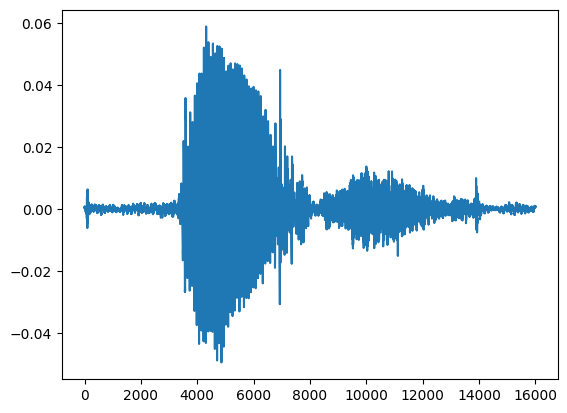

In [40]:
# YES example
waveform, sample_rate = plot_audio(_wav_path)
ipd.Audio(waveform.numpy(), rate=sample_rate)

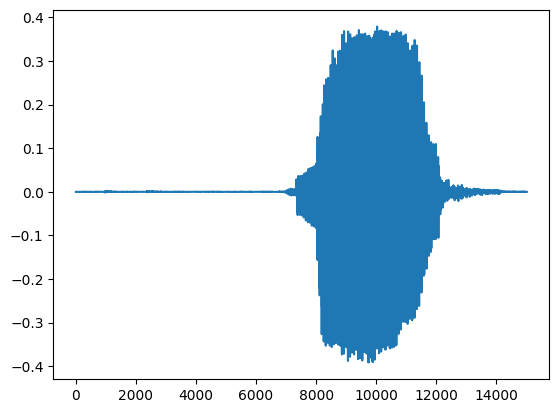

In [62]:
# NO example
_wav_path = _raw_data_path + "no/0ab3b47d_nohash_0.wav"
waveform, sample_rate = plot_audio(_wav_path)
ipd.Audio(waveform.numpy(), rate=sample_rate)

##  Transforming & Visualizing Data
* I use `tf.signal` and `tfio.audio` processing operations to transform the data.
* I create the spectrogram images of the yes/no dataset to be used in the computer vision model.



### Transform Data

In [50]:
train_yes = load_audio_files(_raw_data_path + '/yes', 'yes')
train_no = load_audio_files(_raw_data_path + '/no', 'no')

print(f'Number of yes Samples: {len(train_yes)}')
print(f'NUmber of no Samples: {len(train_no)}')

Number of yes Samples: 1000
NUmber of no Samples: 1000


In [55]:
# Samples of both datasets
print('-' * 50)
print(f'Spiker ID: {train_yes[0][3]}')
print(f'Label: {train_yes[0][2]}')
print(f'Waveform: {train_yes[0][0]}')
print(f'Sample Rate: {train_yes[0][1]}')

print('-' * 50)
print(f'Spiker ID: {train_no[0][3]}')
print(f'Label: {train_no[0][2]}')
print(f'Waveform: {train_no[0][0]}')
print(f'Sample Rate: {train_no[0][1]}')
print('-' * 50)

--------------------------------------------------
Spiker ID: 004ae714
Label: yes
Waveform: [-0.0027771  -0.00537109 -0.00338745 ... -0.00112915 -0.00131226
 -0.00140381]
Sample Rate: 16000
--------------------------------------------------
Spiker ID: 012c8314
Label: no
Waveform: [0.00720215 0.00610352 0.00552368 ... 0.00979614 0.0085144  0.00921631]
Sample Rate: 16000
--------------------------------------------------


### Visualize Data

The data is ready, then visualize the transformed data to understand what they are and what they tell us about the  original data.

#### Waveform

A waveform is a graph that shows a wave's change in displacement over time. A waveform's amplitude controls the wave's maximum displacement.

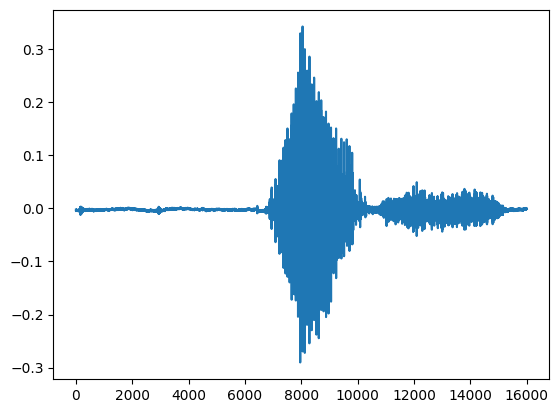

In [59]:
timescale = np.arange(train_yes[0][0].shape[0])
plt.figsize = (12, 8)
plt.plot(timescale, train_yes[0][0].numpy())
plt.show()

#### Convert Waveforms to Spectrograms

The waveforms in the dataset are represented in the time domain. Next, I transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the short-time Fourier transform (STFT) to convert the waveforms to as spectrograms, which show frequency changes over time and can be represented as 2D images.

In [67]:
spectrogram, spect = get_spectrogram(train_yes[0][0])

print('Label:', train_yes[0][2])
print('Waveform shape:', train_yes[0][0].shape)
print('Spectrogram shape:', spectrogram.shape)
print('Spect shape:', spect.shape)
print('Audio playback')

ipd.Audio(train_yes[0][0].numpy(), rate=16000)

Label: yes
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Spect shape: (125, 128)
Audio playback


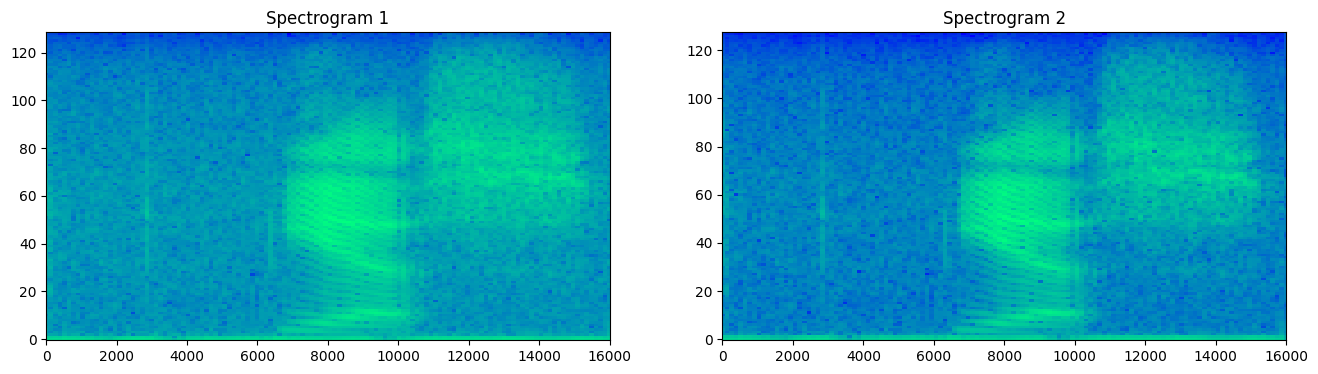

In [86]:
fig, (ax1, ax2) = plt.subplots(figsize=(16, 4), ncols=2)
plot_spectrogram(spectrogram.numpy(), ax1, 'Spectrogram 1')
plot_spectrogram(spect.numpy(), ax2, 'Spectrogram 2')
plt.show()

As we can see, they are identical, therefore both methods work the same.

## Save the Spectrogram

I tried to understand the audio data and different transformations it.
Then, I am going to convert the **Audios** to the **Spectrogram images** to use in classification.

In [88]:
get_images(train_yes, 'yes')
get_images(train_no, 'no')

## Build and train the model